In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pybedtools
import numpy as np

In [3]:
def filter_cent_dist(cent):
    #print(cent)
    if isinstance(cent, float): # for hg19
        return False
    if 'N/A' in cent:
        return False
    else:
        cent = map(int, cent.split(':'))
        return any([i < 1e6 for i in cent])

In [4]:
def filter_cent_dist_indel(cent):
    if isinstance(cent, float): # for hg19
        return False
    if 'N/A' in cent:
        return False
    else:
        cent = map(int, cent.split(','))
        return any([i < 1e6 for i in cent])

In [12]:
def remove_alt_path(test_bed):
    test_bed = test_bed.loc[~((test_bed['#chrom1'].str.contains("[#<>]"))|
                          (test_bed['#chrom1'].str.contains("HG"))), :]
    test_bed = test_bed.loc[~test_bed.read_names.str.contains("normal"), :]
    test_bed = test_bed.loc[~((test_bed['chrom2'].str.contains("[#<>]"))),:]
    test_bed_bnd = test_bed.loc[(test_bed['sv_type']=='bnd') & (test_bed['#chrom1']==test_bed['chrom2']), :].copy()
    test_bed_indel = test_bed.loc[(test_bed['sv_type']=='indel'), :].copy()
    test_bed_bnd = test_bed_bnd.loc[~test_bed_bnd['VNTR_hits'].str.contains("True"), :]
    test_bed_indel.loc[test_bed_indel.VNTR_hits.isna(), 'VNTR_hits'] = 'False'
    test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'
    test_bed_indel = test_bed_indel.loc[~test_bed_indel.loc[:, 'VNTR_hits'], :]
    test_bed_bnd = test_bed_bnd.loc[~test_bed_bnd['Centromere_dist'].map(filter_cent_dist), :]
    test_bed_bnd['counts'] = test_bed_bnd.iloc[:, -4].str.split(',').map(len)
    test_bed_indel['counts'] = test_bed_indel.iloc[:, -4].str.split(',').map(len)
    test_bed_indel = test_bed_indel.loc[~test_bed_indel['Centromere_dist'].map(filter_cent_dist_indel), :]
    return test_bed_bnd, test_bed_indel

/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/3298344906.py:2: DtypeWarning: Columns (2,10,11,12,14,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


      #chrom1    start1      end1 chrom2 start2 end2 name score strand1  \
23226    chr3   6603255   6603257      .      .    .    .     .       .   
23262    chr3   8660369   8660371      .      .    .    .     .       .   
23327    chr3  15538846  15539133      .      .    .    .     .       .   
23328    chr3  15539674  15540144      .      .    .    .     .       .   
23347    chr3  16625897  16625900      .      .    .    .     .       .   

      strand2  ... forward_strand_counts reverse_strand_counts VNTR_hits  \
23226       .  ...                cf:i:0                cr:i:2     False   
23262       .  ...                cf:i:2                cr:i:0     False   
23327       .  ...                cf:i:0                cr:i:2     False   
23328       .  ...                cf:i:0                cr:i:2     False   
23347       .  ...                cf:i:1                cr:i:1     False   

      Centromere_hits                      L1_hits  \
23226           False  AluYk11:0.26366

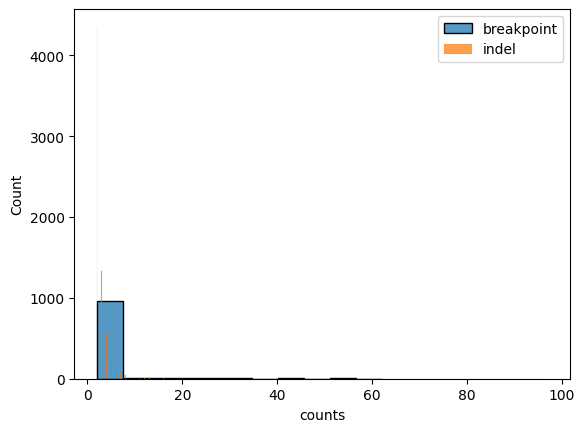

In [13]:
for test_bed_file in glob("chm13*harmonize/*COLO*harmonize*bed.gz"):
    test_bed = pd.read_table(test_bed_file)
    test_bed_bnd, test_bed_indel = remove_alt_path(test_bed)
    test_bed_clean = pd.concat([test_bed_bnd.loc[:, ['#chrom1', 'start1', 'start2', 'counts', 'sv_type']], 
    test_bed_indel.loc[:, ['#chrom1', 'start1', 'end1', 'counts', 'sv_type']].rename({"end1": "start2"}, axis='columns')], axis=0)
    print(test_bed_indel.head())
    #print(test_bed_clean.head())
    print(test_bed_clean.sv_type.value_counts())
    plt.figure()
    sns.histplot(test_bed_bnd['counts'], label='breakpoint')
    sns.histplot(test_bed_indel['counts'], label='indel')
    plt.legend()
    break

In [14]:
test_bed_clean.head()

,#chrom1,start1,start2,counts,sv_type
3,chr1,1761192,1763756,2,bnd
5,chr1,1762940,1763886,2,bnd
9,chr1,5081917,188541381,2,bnd
12,chr1,5985059,16147390,2,bnd
13,chr1,6503261,58826412,2,bnd


In [15]:
#truthset_dict = {"grch38": ['output/truthset_somaticSVs_COLO829_hg38_sort.vcf.gz.PB.bed', 'output/truthset_somaticSVs_COLO829_hg38_sort.vcf.gz.ONT.bed'],
#                 "chm13":['output/truthset.colo829.out.chm13v2.crossmap.vcf.PB.bed', 'output/truthset.colo829.out.chm13v2.crossmap.vcf.ONT.bed'], 
#                 "grch37": ['output/truthset_somaticSVs_COLO829_hg19_sort.vcf.gz.PB.bed', 'output/truthset_somaticSVs_COLO829_hg19_sort.vcf.gz.ONT.bed']}

truthset_dict = {"grch38": ['output/truthset_somaticSVs_COLO829_hg38_sort.vcf.gz.all.bed', 'output/truthset_somaticSVs_COLO829_hg38_sort.vcf.gz.all.bed'],
                 "chm13":['output/truthset.colo829.out.chm13v2.crossmap.vcf.all.bed', 'output/truthset.colo829.out.chm13v2.crossmap.vcf.all.bed'], 
                 "grch37": ['output/truthset_somaticSVs_COLO829_hg19_sort.vcf.gz.all.bed', 'output/truthset_somaticSVs_COLO829_hg19_sort.vcf.gz.all.bed']}

In [16]:
truthset_dict

{'grch38': ['output/truthset_somaticSVs_COLO829_hg38_sort.vcf.gz.all.bed',
  'output/truthset_somaticSVs_COLO829_hg38_sort.vcf.gz.all.bed'],
 'chm13': ['output/truthset.colo829.out.chm13v2.crossmap.vcf.all.bed',
  'output/truthset.colo829.out.chm13v2.crossmap.vcf.all.bed'],
 'grch37': ['output/truthset_somaticSVs_COLO829_hg19_sort.vcf.gz.all.bed',
  'output/truthset_somaticSVs_COLO829_hg19_sort.vcf.gz.all.bed']}

In [20]:
import os
colo_bench_results = []

for test_bed_file in glob("*harmonize/*COLO*harmonize*bed.gz"):
    print(test_bed_file)
    genome = os.path.dirname(test_bed_file).replace("linear_harmonize", "").replace("graph_harmonize", "").replace("_minimap2_harmonize", "")
    gold = truthset_dict[genome]

    test_bed = pd.read_table(test_bed_file)
    test_bed_bnd, test_bed_indel = remove_alt_path(test_bed)
    test_bed_clean = pd.concat([test_bed_bnd.loc[:, ['#chrom1', 'start1', 'start2', 'counts', 'sv_type']], 
                                 test_bed_indel.loc[:, ['#chrom1', 'start1', 'end1', 'counts', 'sv_type']].rename({"end1": "start2"}, axis='columns')], axis=0)
    print(test_bed_clean.sv_type.value_counts())

    if 'ONT' in test_bed_file:
        gold = pd.read_table(gold[1], header=None)
        if 'grch37' not in test_bed_file:
            gold.iloc[:, 0] = gold.iloc[:, 0].map(lambda x: "chr%s" % x)
        gold = gold.iloc[:, [0, 1, 2, 4]]
        #print(gold.iloc[:, 2] - gold.iloc[:, 1])
    else:
        gold = pd.read_table(gold[0], header=None)
        if 'grch37' not in test_bed_file:
            gold.iloc[:, 0] = gold.iloc[:, 0].map(lambda x: "chr%s" % x)
        gold = gold.iloc[:, [0, 1, 2, 4]]
        #print(gold.iloc[:, 2] - gold.iloc[:, 1])

    #NOTE: do not reorder start and end
    #  due to potential inversion and duplication

    #start = test_bed_clean.apply(lambda x: x[2] if int(x[1]) > int(x[2]) else x[1], axis=1)
    #end = test_bed_clean.apply(lambda x: x[1] if int(x[1]) > int(x[2]) else x[2], axis=1)
    #test_bed_clean.loc[:, 'start1'] = start
    #test_bed_clean.loc[:, 'start2'] = end
    print(pd.crosstab(test_bed_clean.start2.astype(int) - test_bed_clean.start1.astype(int) > 0, test_bed_clean.sv_type))

    test_bed_clean = test_bed_clean.loc[test_bed_clean.start2.astype(int) - test_bed_clean.start1.astype(int) >= 50, :]
    our_sv = pybedtools.BedTool.from_dataframe(test_bed_clean)
    our_sv_df = our_sv.sort().merge(d=200, c=4, o='sum').to_dataframe()
    our_sv_filter = pybedtools.BedTool.from_dataframe(our_sv_df.loc[our_sv_df.iloc[:, -1] >= 10, :])
    gold_sv = pybedtools.BedTool.from_dataframe(gold)
    colo_bench_results.append([test_bed_file, our_sv_filter.sort().merge(d=200).count(), gold_sv.sort().merge(d=200).count(), gold_sv.sort().merge(d=200).intersect(our_sv_filter.sort().merge(d=200), wa=True, u=True).count(), our_sv_filter.sort().merge().intersect(gold_sv.sort().merge(d=200), wa=True, u=True).count()])
    #colo_bench_results.append([test_bed_file, our_sv.sort().merge(d=200).count(), gold_sv.sort().merge(d=200).count(), gold_sv.sort().merge().intersect(our_sv, wa=True, u=True).count(), gold_sv.intersect(our_sv, wa=True, u=True).count(), our_sv.sort().merge().intersect(gold_sv, wa=True, u=True).count()])

chm13_minimap2_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/3597780500.py:9: DtypeWarning: Columns (2,10,11,12,14,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    6959
bnd      1004
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    558      0
True     446   6959
chm13_minimap2_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/3597780500.py:9: DtypeWarning: Columns (2,10,11,12,14,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    1412
bnd       101
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False     46      0
True      55   1412
grch37linear_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/3597780500.py:9: DtypeWarning: Columns (2,4,10,11,12,14,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    7370
bnd      4264
Name: sv_type, dtype: int64
sv_type   bnd  indel
row_0               
False    2583      0
True     1681   7370
grch37linear_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/3597780500.py:9: DtypeWarning: Columns (2,10,11,12,14,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    2622
bnd      1119
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    640      0
True     479   2622
chm13graph_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/3597780500.py:9: DtypeWarning: Columns (2,10,11,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    1633
bnd       807
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    480      0
True     327   1633
chm13graph_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    86
bnd      54
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False     21      0
True      33     86
grch38graph_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/3597780500.py:9: DtypeWarning: Columns (2,10,11,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    2019
bnd      1441
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    881      0
True     560   2019
grch38graph_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


bnd      241
indel    104
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    134      0
True     107    104
grch37_minimap2_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/3597780500.py:9: DtypeWarning: Columns (2,4,10,11,12,14,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    10160
bnd       4252
Name: sv_type, dtype: int64
sv_type   bnd  indel
row_0               
False    2400      0
True     1852  10160
grch37_minimap2_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/3597780500.py:9: DtypeWarning: Columns (2,10,11,12,14,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    3624
bnd      2145
Name: sv_type, dtype: int64
sv_type   bnd  indel
row_0               
False    1158      0
True      987   3624
chm13linear_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/3597780500.py:9: DtypeWarning: Columns (2,10,11,12,14,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    6762
bnd       916
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    534      0
True     382   6762
chm13linear_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/3597780500.py:9: DtypeWarning: Columns (2,10,11,12,14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    1260
bnd        89
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False     41      0
True      48   1260
grch38_minimap2_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/3597780500.py:9: DtypeWarning: Columns (2,10,11,12,14,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    9639
bnd      1672
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    991      0
True     681   9639
grch38_minimap2_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/3597780500.py:9: DtypeWarning: Columns (2,10,11,12,14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    2267
bnd       441
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    228      0
True     213   2267
grch38linear_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/3597780500.py:9: DtypeWarning: Columns (2,10,11,12,14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    9277
bnd      1991
Name: sv_type, dtype: int64
sv_type   bnd  indel
row_0               
False    1237      0
True      754   9277
grch38linear_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/3597780500.py:9: DtypeWarning: Columns (2,10,11,12,14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    1998
bnd       387
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    231      0
True     156   1998
grch37graph_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/3597780500.py:9: DtypeWarning: Columns (2,4,10,11,12,14,19) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


bnd      4077
indel    1184
Name: sv_type, dtype: int64
sv_type   bnd  indel
row_0               
False    2403      0
True     1674   1184
grch37graph_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_18439/669056339.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


bnd      1110
indel     132
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    641      0
True     469    132


In [21]:
final_table = pd.DataFrame(colo_bench_results)
final_table.columns = ['dataset_assembly', 'merged_our_sv_filter', 'merged_truthset', 'merged_true_positive_hits', 'all_hits']

In [24]:
final_table.loc[:, 'platform'] = np.where(final_table.dataset_assembly.str.contains("ONT"), "ONT", "HIFI")
final_table.loc[:, 'structure'] = np.where(final_table.dataset_assembly.str.contains("linear"), "linear", "graph")
final_table.loc[:, 'assembly'] = final_table.dataset_assembly.map(lambda x: os.path.dirname(x).replace("linear_harmonize", "").replace("graph_harmonize", "").replace("_minimap2_harmonize", ""))


In [25]:
final_table

,dataset_assembly,merged_our_sv_filter,merged_truthset,merged_true_positive_hits,all_hits,platform,structure,assembly
0,chm13_minimap2_harmonize/COLO829_ONT_mapq5_mle...,219,27,27,18,ONT,graph,chm13
1,chm13_minimap2_harmonize/COLO829_mapq5_mlen50_...,56,27,22,21,HIFI,graph,chm13
2,grch37linear_harmonize/COLO829_ONT_mapq5_mlen5...,162,28,28,19,ONT,linear,grch37
3,grch37linear_harmonize/COLO829_mapq5_mlen50_su...,60,28,22,21,HIFI,linear,grch37
4,chm13graph_harmonize/COLO829_ONT_mapq5_mlen50_...,43,27,27,19,ONT,graph,chm13
5,chm13graph_harmonize/COLO829_mapq5_mlen50_supp...,28,27,22,22,HIFI,graph,chm13
6,grch38graph_harmonize/COLO829_ONT_mapq5_mlen50...,49,28,28,19,ONT,graph,grch38
7,grch38graph_harmonize/COLO829_mapq5_mlen50_sup...,29,28,21,21,HIFI,graph,grch38
8,grch37_minimap2_harmonize/COLO829_ONT_mapq5_ml...,172,28,28,19,ONT,graph,grch37
9,grch37_minimap2_harmonize/COLO829_mapq5_mlen50...,80,28,22,22,HIFI,graph,grch37


In [14]:
final_table.to_csv("COLO829_tumor_only_evaluation_across_assembly.csv")

In [2]:
%pwd

'/home/ubuntu/pangenome/pangenome_sv_benchmarking/2c.tumor_normal_pair_somatic_evaluation'

In [16]:
from plotnine import *

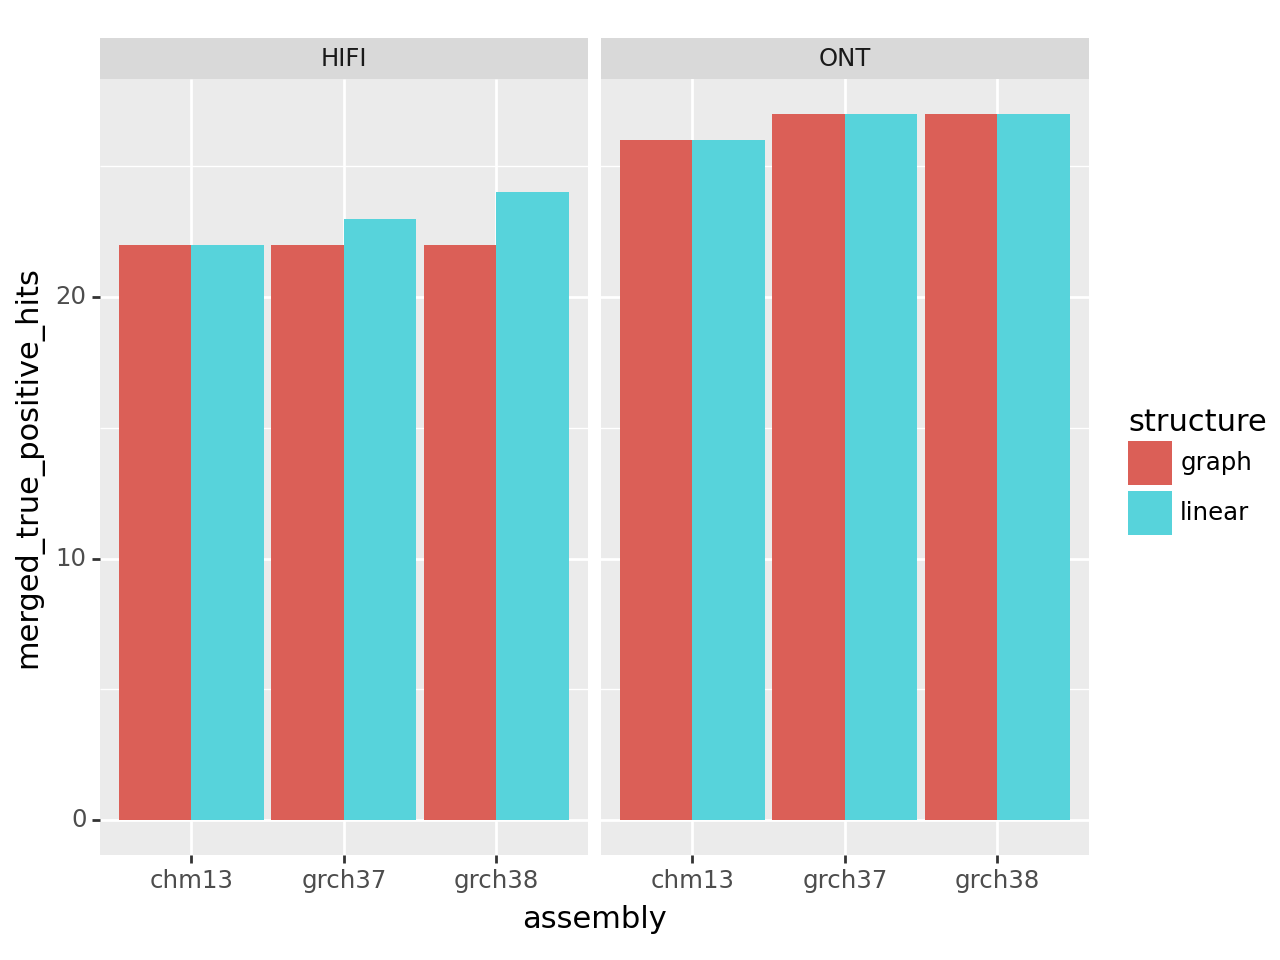

<Figure Size: (640 x 480)>

In [17]:
(ggplot(final_table, aes('assembly', 'merged_true_positive_hits', fill='structure'))
 + geom_col(position='dodge', width=.95) + facet_wrap("platform"))